<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/llibre-estil/logo-UOC-masterbrand.jpg" align="left">
</div>
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">TFM - UEBA: Detección de Anomalías</p>
<p style="margin: 0; text-align:right;">20231 - Máster universitario en Ciencias de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicaciones</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos:</strong> Alejandro Ortega de los Ríos
</div>

# MODELO SUPERVISADO - CLASIFICACIÓN

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Cargo dataset de características
features_df = pd.read_csv('../processing/features_graph.csv')
features_df.drop(columns=['Unnamed: 0'], inplace=True)

## 1. Oversampling

In [3]:
# Divido los datos en características (X) y objetivo (y)
X = features_df.drop(columns=['user', 'insider'])
y = features_df['insider']

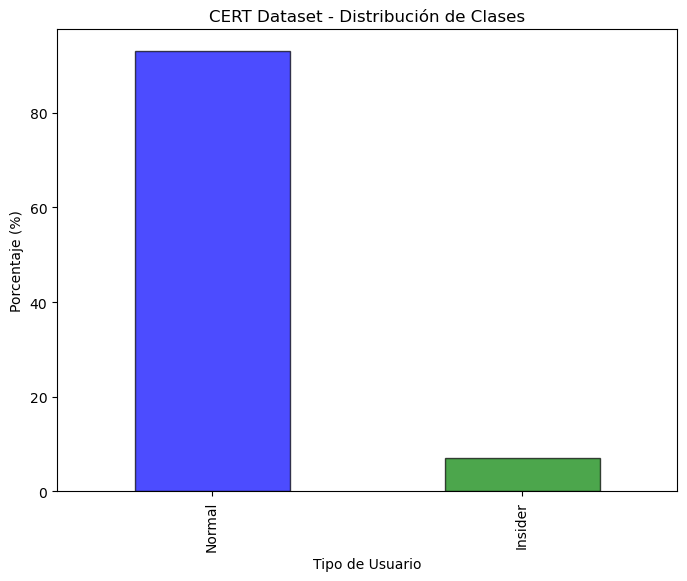

In [4]:
# Variable objetivo - Diagrama de barras
insider_counts = y.value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
insider_counts.plot(kind='bar', edgecolor='black', alpha = 0.7, color=['blue', 'green'])
plt.title('CERT Dataset - Distribución de Clases')
plt.xlabel('Tipo de Usuario')
plt.ylabel('Porcentaje (%)')
plt.xticks([0, 1], ['Normal', 'Insider'])
plt.savefig('../img/unbalanced_barplot.jpg')
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>    
Como norma general, los algoritmos de ML tienden una tendencia natural hacia la clase mayoritaria. En caso de
conjuntos desbalanceados, es necesario recurrir a una serie de técnicas. En este caso se va a optar por la
generación sintética de outliers, por medio de SMOTE.
<br><br>
</div>

In [5]:
#Oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

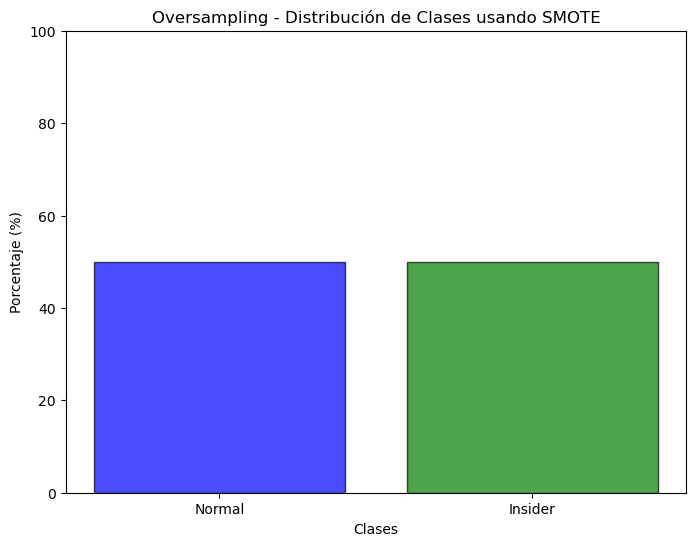

In [6]:
plt.figure(figsize=(8, 6))
class_counts = pd.Series(y_resampled).value_counts(normalize=True) * 100
plt.bar(class_counts.index, class_counts.values, edgecolor='black', alpha = 0.7, color=['blue', 'green'])

plt.xlabel('Clases')
plt.ylabel('Porcentaje (%)')
plt.title('Oversampling - Distribución de Clases usando SMOTE')
plt.ylim(0, 100)
plt.xticks(class_counts.index, ['Normal', 'Insider'])
plt.savefig('../img/oversampling_smote.jpg')

plt.show()

In [7]:
print("Distribución de clases antes de SMOTE:\n", y.value_counts())
print("Distribución de clases después de SMOTE:\n", pd.Series(y_resampled).value_counts())

Distribución de clases antes de SMOTE:
 0    930
1     70
Name: insider, dtype: int64
Distribución de clases después de SMOTE:
 0    930
1    930
Name: insider, dtype: int64


In [8]:
#Divido en conjunto en entrenamiento y prueba estratificados
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, 
                                                    stratify=y_resampled)

## 2. Enfoques tradicionales

Voy a tomar como punto de partida algoritmos de aprendizaje tradicionales, que servirán como baseline de futuros modelos:

    - Máquinas de Soporte Vectorial (SVM)
    - Random Forest (RF)

### 2.1. Máquinas de Soporte Vectorial

In [9]:
#Máquinas de soporte vectorial
svm = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10, 100], 
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf']
}

#GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Ajusto el modelo y lo entreno
grid_search.fit(X_train, y_train)
best_params_svm = grid_search.best_params_
best_model_svm = grid_search.best_estimator_

print("Mejores hiperparámetros:", best_params_svm)

Mejores hiperparámetros: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [10]:
# Validación del modelo
y_pred_svm = best_model_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       186
           1       0.87      0.92      0.90       186

    accuracy                           0.89       372
   macro avg       0.89      0.89      0.89       372
weighted avg       0.89      0.89      0.89       372



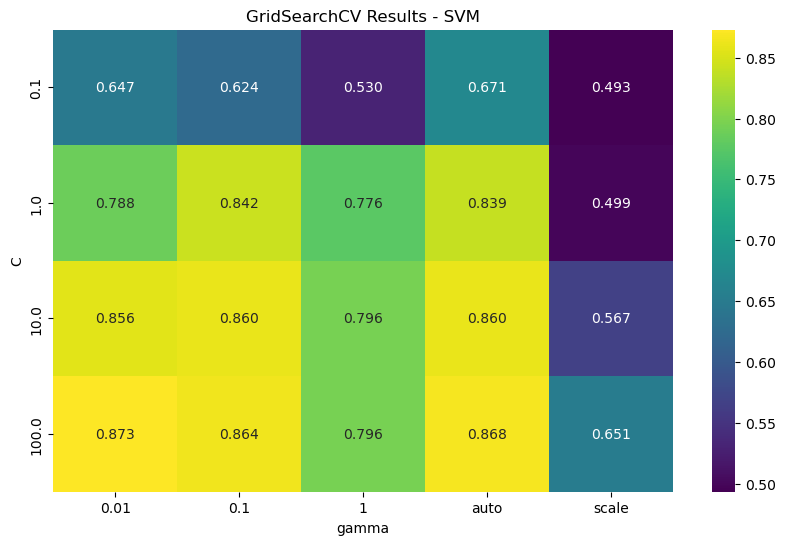

In [11]:
# Ajuste de hiperparámetros - Mapa de calor
cv_results = pd.DataFrame(grid_search.cv_results_)

cv_results = cv_results[['param_C', 'param_gamma', 'mean_test_score']]
pivot_table = cv_results.pivot('param_C', 'param_gamma', 'mean_test_score')

plt.figure(figsize=(10, 6))
plt.title('GridSearchCV Results - SVM')
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='viridis')
plt.xlabel('gamma')
plt.ylabel('C')
plt.savefig('../img/gridsearch_svm_heatmap.jpg')
plt.show()

### 2.2. Random Forest

In [12]:
rf = RandomForestClassifier()

# Hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Entreno el modelo
grid_search.fit(X_train, y_train)
best_params_rf = grid_search.best_params_
best_model_rf = grid_search.best_estimator_

print("Mejores hiperparámetros:", best_params_rf)

Mejores hiperparámetros: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [13]:
# Validación del modelo
y_pred_rf = best_model_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       186
           1       0.93      1.00      0.97       186

    accuracy                           0.97       372
   macro avg       0.97      0.97      0.97       372
weighted avg       0.97      0.97      0.97       372



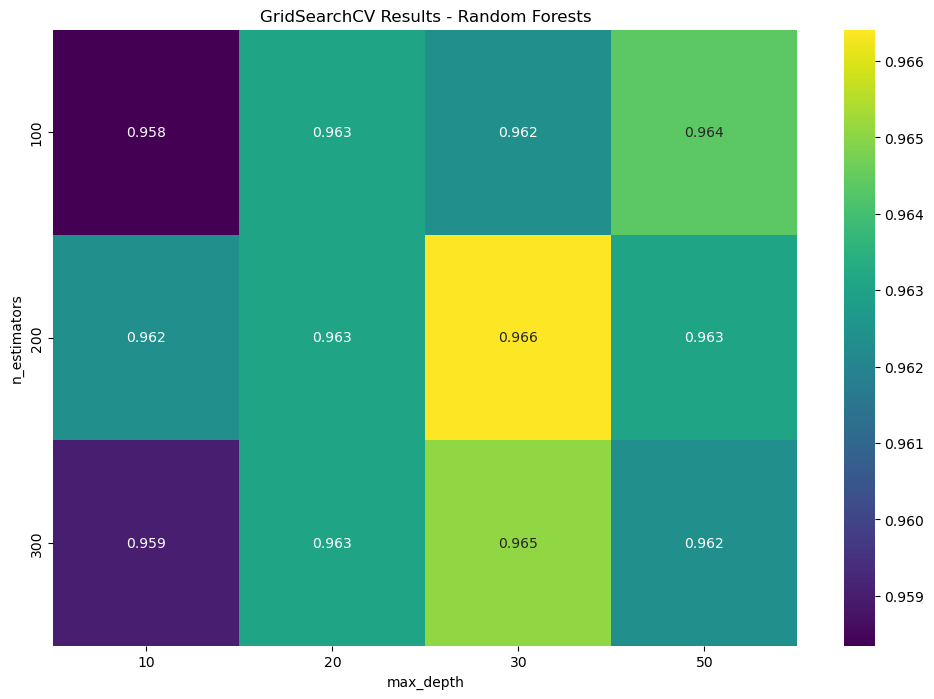

In [14]:
# Ajuste de hiperparámetros - Mapa de calor (n_estimators, max_depth)
cv_results = pd.DataFrame(grid_search.cv_results_)

cv_results_1 = cv_results[['param_n_estimators', 'param_max_depth', 'mean_test_score']]
cv_results_1 = cv_results_1.sort_values(by='mean_test_score', ascending=False)
cv_results_1 = cv_results_1.drop_duplicates(['param_n_estimators', 'param_max_depth'])

pivot_table = cv_results_1.pivot('param_n_estimators', 'param_max_depth', 'mean_test_score')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='viridis')
plt.title('GridSearchCV Results - Random Forests')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.savefig('../img/gridsearch_rf_heatmap.jpg')
plt.show()

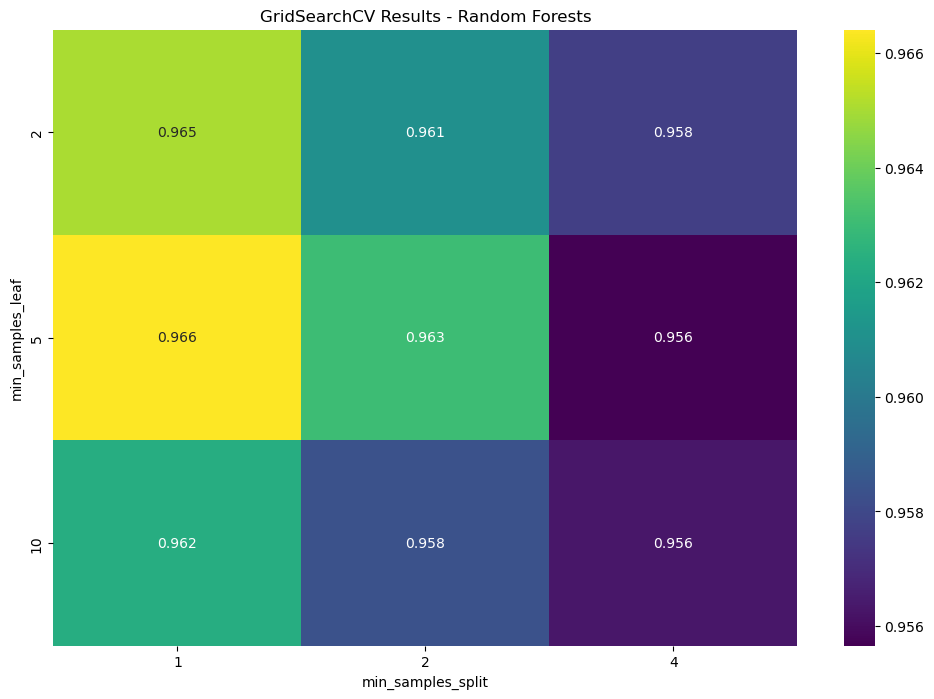

In [15]:
# Ajuste de hiperparámetros - Mapa de calor (min_samples_split, min_samples_leaf)
cv_results_2 = cv_results[['param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']]
cv_results_2 = cv_results_2.sort_values(by='mean_test_score', ascending=False)
cv_results_2 = cv_results_2.drop_duplicates(['param_min_samples_split', 'param_min_samples_leaf'])

pivot_table = cv_results_2.pivot('param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='viridis')
plt.title('GridSearchCV Results - Random Forests')
plt.xlabel('min_samples_split')
plt.ylabel('min_samples_leaf')
plt.savefig('../img/gridsearch_rf_heatmap_1.jpg')
plt.show()

In [17]:
#Probabilidades de predicción (necesarias para pintar curva ROC-AUC)
y_prob_svm = best_model_svm.predict_proba(X_test)[:, 1]
y_prob_rf = best_model_rf.predict_proba(X_test)[:, 1]

## 3. Modelos Híbridos

### 3.1. Construcción del Modelo

Voy a usar el ensamblador Gradient Boosting. Se usarán las predicciones de los algortimos de detección de anomalías Isolation Forest y DBLOF (prescindiré de OCSVM, dado que fue el que dió peores resultados), junto con los modelos de clasificación generados (escojo Random Forests, en vista a los resultados obtenidos). 

In [18]:
#Realizo predicciones con los modelos de Detección de Anomalías con el conjunto X_test

#Isolation Forests
iso_forest = IsolationForest(contamination=0.5, n_estimators=200, max_samples=256, random_state=42)
iso_forest.fit(X_train)
y_pred_if = iso_forest.predict(X_test)

#DBLOF
dblof = LocalOutlierFactor(n_neighbors=5, contamination=0.5)
y_pred_dblof = dblof.fit_predict(X_test)

#IF, DBLOF devuelven -1 (outlier) o 1 (inlier). Modifico el array para que sea 0 (inlier) 1 (outlier)
y_pred_if = np.where(y_pred_if == 1, 0, y_pred_if)
y_pred_if = np.where(y_pred_if == -1, 1, y_pred_if)

y_pred_dblof = np.where(y_pred_dblof == 1, 0, y_pred_if)
y_pred_dblof = np.where(y_pred_dblof == -1, 1, y_pred_if)

In [23]:
#Stacking para combinar predicciones de los modelos
X_stacking = np.column_stack((y_pred_if, y_pred_dblof, y_pred_rf))

#Oversampling
X_stacking, y_stacking = smote.fit_resample(X_stacking, y_test)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_stacking, y_stacking, stratify=y_stacking,
                                                    test_size=0.2, random_state=42)

Mejores hiperparámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}


In [32]:
gb = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

grid_search = GridSearchCV(gb, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

#Entreno el modelo
grid_search.fit(X_train1, y_train1)
best_params_gb = grid_search.best_params_
best_model_gb = grid_search.best_estimator_

print("Mejores hiperparámetros:", best_params_gb)

Mejores hiperparámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}


In [33]:
# Validación del modelo
y_pred_gb = best_model_gb.predict(X_test1)
print(classification_report(y_test1, y_pred_gb))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        38
           1       0.95      1.00      0.97        37

    accuracy                           0.97        75
   macro avg       0.97      0.97      0.97        75
weighted avg       0.97      0.97      0.97        75



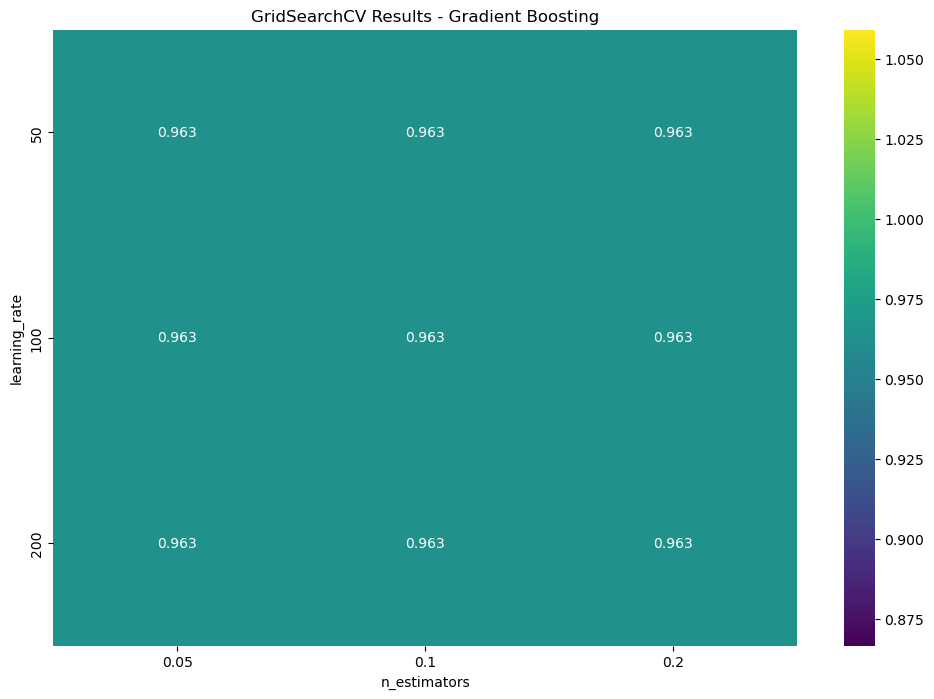

In [49]:
# Ajuste de hiperparámetros - Mapa de calor (n_estimators, learning_rate)
cv_results = pd.DataFrame(grid_search.cv_results_)

cv_results_1 = cv_results[['param_n_estimators', 'param_learning_rate', 'mean_test_score']]
cv_results_1 = cv_results_1.sort_values(by='mean_test_score', ascending=False)
cv_results_1 = cv_results_1.drop_duplicates(['param_n_estimators', 'param_learning_rate'])

pivot_table = cv_results_1.pivot('param_n_estimators', 'param_learning_rate', 'mean_test_score')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='viridis')
plt.title('GridSearchCV Results - Gradient Boosting')
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')
plt.savefig('../img/gridsearch_gb_heatmap_1.jpg')
plt.show()

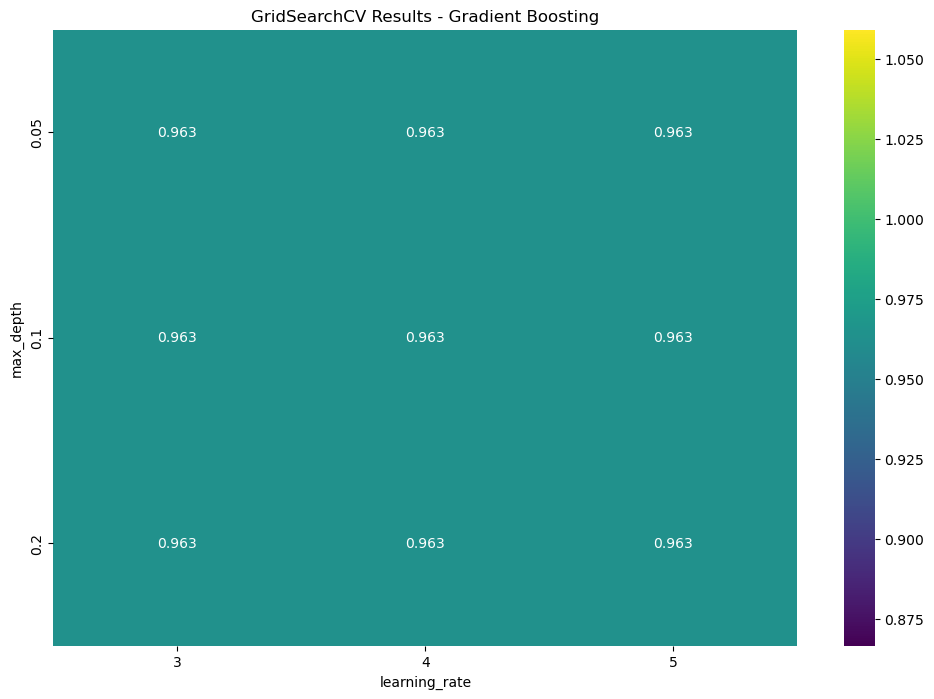

In [50]:
# Ajuste de hiperparámetros - Mapa de calor (learning_rate, max_depth)
cv_results = pd.DataFrame(grid_search.cv_results_)

cv_results_1 = cv_results[['param_learning_rate', 'param_max_depth', 'mean_test_score']]
cv_results_1 = cv_results_1.sort_values(by='mean_test_score', ascending=False)
cv_results_1 = cv_results_1.drop_duplicates(['param_learning_rate', 'param_max_depth'])

pivot_table = cv_results_1.pivot('param_learning_rate', 'param_max_depth', 'mean_test_score')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='viridis')
plt.title('GridSearchCV Results - Gradient Boosting')
plt.xlabel('learning_rate')
plt.ylabel('max_depth')
plt.savefig('../img/gridsearch_gb_heatmap_2.jpg')
plt.show()

## 4. Validación Cruzada

A continuación muestro los resultados obtenidos durante cada iteración al realizar la validación cruzada

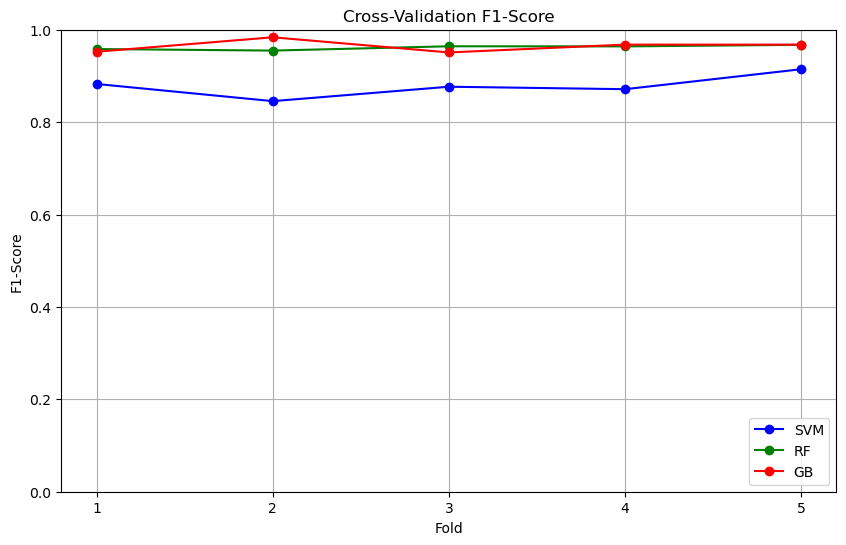

In [41]:
#Validación Cruzada
cv_scores_svm = cross_val_score(best_model_svm, X_train, y_train, cv=5, scoring='f1')
cv_scores_rf = cross_val_score(best_model_rf, X_train, y_train, cv=5, scoring='f1')
cv_scores_gb = cross_val_score(best_model_gb, X_train1, y_train1, cv=5, scoring='f1')

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cv_scores_svm) + 1), cv_scores_svm, marker='o', linestyle='-', color='blue', label='SVM')
plt.plot(range(1, len(cv_scores_rf) + 1), cv_scores_rf, marker='o', linestyle='-', color='green', label='RF')
plt.plot(range(1, len(cv_scores_gb) + 1), cv_scores_gb, marker='o', linestyle='-', color='red', label='GB')
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.title('Cross-Validation F1-Score')
plt.ylim(0, 1)
plt.xticks(range(1, len(cv_scores_svm) + 1))
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig('../img/cross_validation.jpg')
plt.show()


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
Resultados: los resultados obtenidos muestran una alta capacidad de ambos modelos para predecir insiders. Además, en vista a la gráfica de Cross Validation, los resultados no son sensibles al conjunto de entrenamiento de partida, por lo que parece que no existe sobreajuste.
<br><br>
</div>

## 5. Curva ROC-AUC

Esta curva permite representar la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) a diferentes umbrales de decisión, facilitando la evaluación del rendimiento del modelo en la clasificación de anomalías. Los valores de referencia son:

-	0.97 ≤ AUC ≤ 1: excelente.
-	0.9 ≤ AUC < 0.97: muy bueno.
-	0.75 ≤ AUC < 0.9: bueno
-	0.6 ≤ AUC < 0.75: regular
-	0.5 ≤ AUC < 0.6: malo
-	AUC = 0.5: sin discriminación (equivalente a un clasificador aleatorio).

In [45]:
y_prob_final = best_model_gb.predict_proba(X_test1)[:, 1]

# Calculo las curvas ROC del modelo híbrido
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_final, tpr_final, _ = roc_curve(y_test1, y_prob_final)
roc_auc_final = auc(fpr_final, tpr_final)

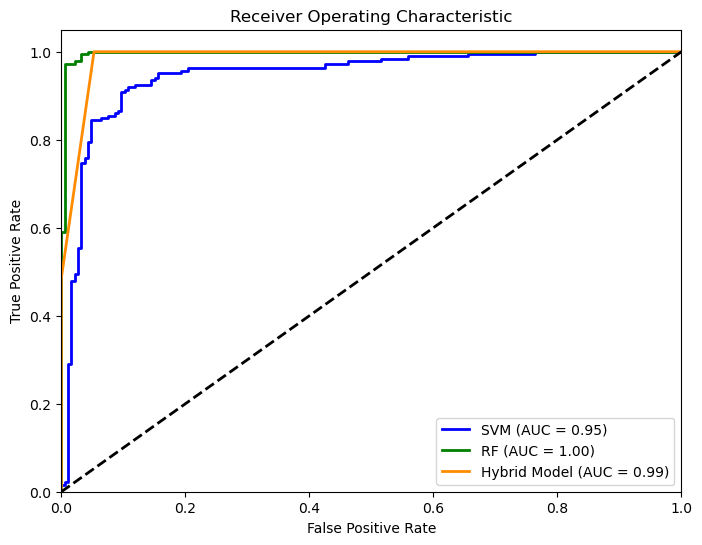

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'RF (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_final, tpr_final, color='darkorange', lw=2, label=f'Hybrid Model (AUC = {roc_auc_final:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('../img/final_roc.jpg')
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
La curva ROC-AUC muestra que en general todos los modelos presentan un rendimiento excelente, y que en concreto en modelo híbrido ha permitido una mejora con respecto a SVM, pero no contra RF.
<br><br>
</div>